In [73]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [74]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [75]:
import fastai; fastai.__version__

'2.1.5'

In [78]:
print("python " + sys.version)

python 3.8.6 | packaged by conda-forge | (default, Oct  7 2020, 19:08:05) 
[GCC 7.5.0]


In [79]:
key = os.environ.get('AZURE_SEARCH_KEY', '94ab940461bd46de858f6731816c7a71')

Or, if you're comfortable at the command line, you can set it in your terminal with:

    export AZURE_SEARCH_KEY=your_key_here

and then restart Jupyter Notebook, and use the above line without editing it.

Once you've set `key`, you can use `search_images_bing`. This function is provided by the small `utils` class included with the notebooks online. If you're not sure where a function is defined, you can just type it in your notebook to find out:

In [80]:
 def search_images_bing(key, term, max_images: int = 150, **kwargs):    
     params = {'q':term, 'count':max_images}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

In [81]:
search_images_bing

<function __main__.search_images_bing(key, term, max_images: int = 150, **kwargs)>

In [82]:
results = search_images_bing(key, 'dogs')
ims = results.attrgot('content_url')
len(ims)

150

In [83]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [84]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

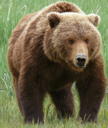

In [85]:
im = Image.open(dest)
im.to_thumb(128,128)

In [86]:
bear_types = 'german shepherd','corgi','husky'
path = Path('dogs')

In [87]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} dog')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [88]:
fns = get_image_files(path)
fns

(#445) [Path('dogs/german shepherd/00000047.jpg'),Path('dogs/german shepherd/00000055.jpg'),Path('dogs/german shepherd/00000064.png'),Path('dogs/german shepherd/00000075.jpeg'),Path('dogs/german shepherd/00000107.jpg'),Path('dogs/german shepherd/00000036.jpg'),Path('dogs/german shepherd/00000030.jpg'),Path('dogs/german shepherd/00000097.jpg'),Path('dogs/german shepherd/00000148.jpg'),Path('dogs/german shepherd/00000110.jpg')...]

In [89]:
failed = verify_images(fns)
failed

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


(#0) []

In [90]:
failed.map(Path.unlink);

In [91]:
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [92]:
dls = dogs.dataloaders(path)

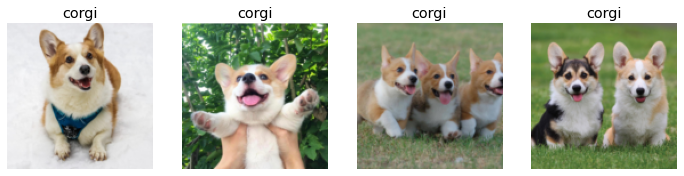

In [93]:
dls.valid.show_batch(max_n=4, nrows=1)

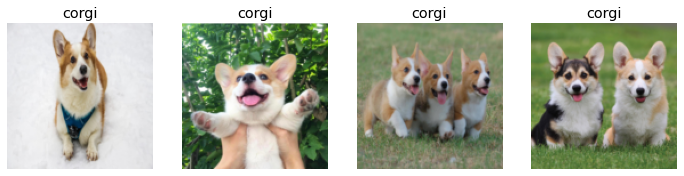

In [94]:
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

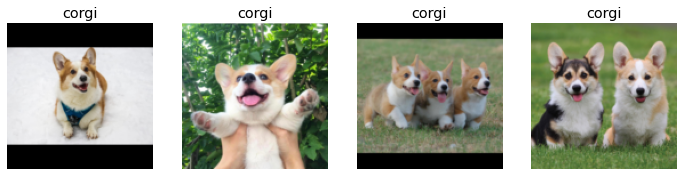

In [95]:
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

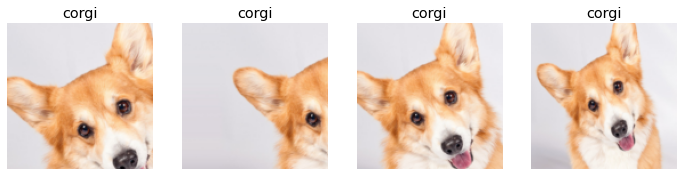

In [96]:
dogs = dogs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

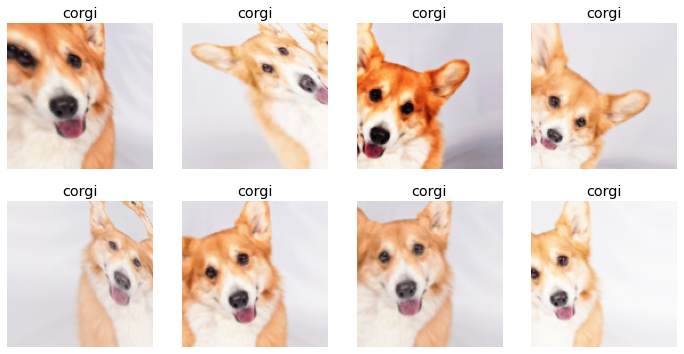

In [97]:
dogs = dogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [98]:
dogs = dogs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = dogs.dataloaders(path)

In [99]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.360468,0.031847,0.000000,00:11


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


epoch,train_loss,valid_loss,error_rate,time
0,0.185766,0.014766,0.000000,00:11
1,0.143984,0.008994,0.000000,00:11
2,0.108431,0.004023,0.000000,00:11
3,0.084799,0.004050,0.000000,00:12


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


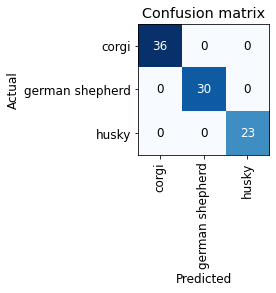

In [100]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

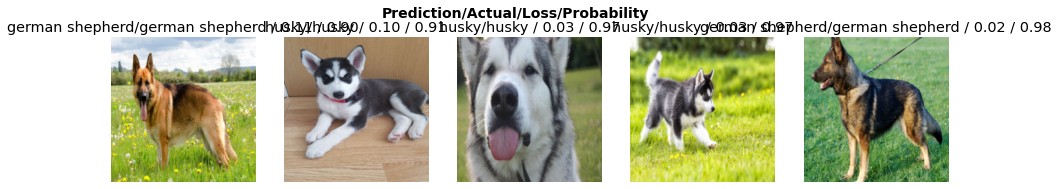

In [101]:
interp.plot_top_losses(5, nrows=1)

In [102]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [103]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [104]:
learn.export()

In [105]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [106]:
learn_inf = load_learner(path/'export.pkl')

In [107]:
learn_inf.predict('images/grizzly.jpg')

('german shepherd', TensorImage(1), TensorImage([0.0010, 0.9882, 0.0108]))

In [108]:
learn_inf.dls.vocab

['corgi', 'german shepherd', 'husky']

In [109]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [110]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [111]:
img = PILImage.create(btn_upload.data[-1])

In [112]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [113]:
pred,pred_idx,probs = learn_inf.predict(img)

In [114]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: german shepherd; Probability: 0.9882')

In [115]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [116]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [117]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [118]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [119]:
#hide
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila 